In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-20 19:52:47.849737: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "./dataset_6/train"
val_path = "./dataset_6/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-20 19:52:50.768368: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 19:52:51.356672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 19266 files belonging to 3 classes.
Found 2142 files belonging to 3 classes.


In [16]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


### Test set

In [5]:
with tf.device("CPU"):
    AUTOTUNE = tf.data.AUTOTUNE
#     val_batches = tf.data.experimental.cardinality(val_ds)
#     test_dataset = val_ds.take(val_batches // 2)
#     validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = val_ds.prefetch(buffer_size = AUTOTUNE)
#     validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
#     test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(validation_dataset))
# print(len(test_dataset))

67


## Model building

In [7]:
def build_vgg16(dropout_num=0.2):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_num))
    model.add(Dense(3, activation='softmax'))  
    
    return model

In [8]:
with tf.device("GPU"):
    model = build_vgg16(0.4)

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [9]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn6_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [10]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks, checkpoints_cb])

Epoch 1/30


2023-06-20 19:53:22.033263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-20 19:53:23.340515: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


603/603 [==============================] - ETA: 0s - loss: 0.9998 - accuracy: 0.5551

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 107s 170ms/step - loss: 0.9998 - accuracy: 0.5551 - val_loss: 0.9912 - val_accuracy: 0.5560
Epoch 2/30
603/603 [==============================] - ETA: 0s - loss: 0.9801 - accuracy: 0.5596

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 101s 167ms/step - loss: 0.9801 - accuracy: 0.5596 - val_loss: 0.9802 - val_accuracy: 0.5570
Epoch 3/30
602/603 [============================>.] - ETA: 0s - loss: 0.9024 - accuracy: 0.5985

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 101s 167ms/step - loss: 0.9025 - accuracy: 0.5985 - val_loss: 0.9892 - val_accuracy: 0.5373
Epoch 4/30
602/603 [============================>.] - ETA: 0s - loss: 0.7863 - accuracy: 0.6566

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 101s 167ms/step - loss: 0.7864 - accuracy: 0.6565 - val_loss: 1.0785 - val_accuracy: 0.5187
Epoch 5/30
602/603 [============================>.] - ETA: 0s - loss: 0.6084 - accuracy: 0.7393

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 100s 166ms/step - loss: 0.6084 - accuracy: 0.7393 - val_loss: 1.4066 - val_accuracy: 0.4720
Epoch 6/30
602/603 [============================>.] - ETA: 0s - loss: 0.3610 - accuracy: 0.8583

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 101s 167ms/step - loss: 0.3610 - accuracy: 0.8584 - val_loss: 2.0160 - val_accuracy: 0.5294
Epoch 7/30
602/603 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9458

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 100s 167ms/step - loss: 0.1574 - accuracy: 0.9458 - val_loss: 2.4884 - val_accuracy: 0.4897
Epoch 8/30
602/603 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9738

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 101s 167ms/step - loss: 0.0862 - accuracy: 0.9738 - val_loss: 3.2523 - val_accuracy: 0.4776
Epoch 9/30
602/603 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9866

INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 101s 167ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 3.4027 - val_accuracy: 0.4869
Epoch 10/30
602/603 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9905
Reached 99% accuracy, cancelling training


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn6_checkpoints/assets


603/603 [==============================] - 100s 167ms/step - loss: 0.0316 - accuracy: 0.9905 - val_loss: 4.0058 - val_accuracy: 0.5219


In [11]:
model.save('./models/cnn6_10epoch.h5')

### Training evaluation

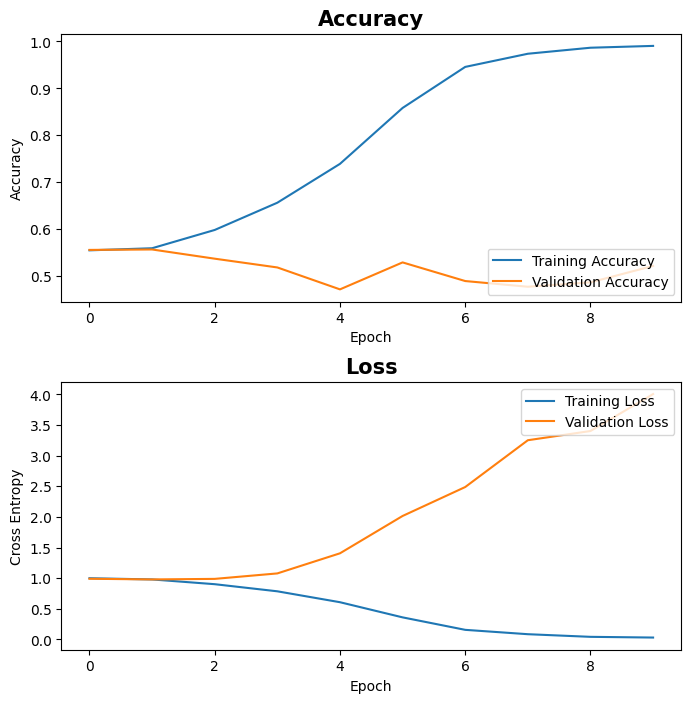

In [12]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [13]:
acc

[0.5551230311393738,
 0.5595868229866028,
 0.598515510559082,
 0.6565452218055725,
 0.7392816543579102,
 0.8583515286445618,
 0.9457593560218811,
 0.9737880229949951,
 0.9866085052490234,
 0.9905014038085938]

In [14]:
val_acc

[0.5560224056243896,
 0.5569561123847961,
 0.5373482704162598,
 0.5186741352081299,
 0.4719887971878052,
 0.529411792755127,
 0.48972922563552856,
 0.47759103775024414,
 0.4869281053543091,
 0.521942138671875]

In [15]:
loss

[0.9998354911804199,
 0.9801017642021179,
 0.9025158882141113,
 0.7863630056381226,
 0.608415961265564,
 0.36103054881095886,
 0.1574304848909378,
 0.08624022454023361,
 0.04323240742087364,
 0.031642019748687744]

In [16]:
val_loss

[0.9912123084068298,
 0.9802477359771729,
 0.9892183542251587,
 1.0784567594528198,
 1.4065985679626465,
 2.016023635864258,
 2.4883594512939453,
 3.252277135848999,
 3.402705192565918,
 4.0057573318481445]

## Testing

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [20]:
result = model.evaluate(validation_dataset)
dict(zip(model.metrics_names, result))

67/67 [==============================] - 4s 56ms/step - loss: 4.0058 - accuracy: 0.5219


{'loss': 4.005771636962891, 'accuracy': 0.521942138671875}

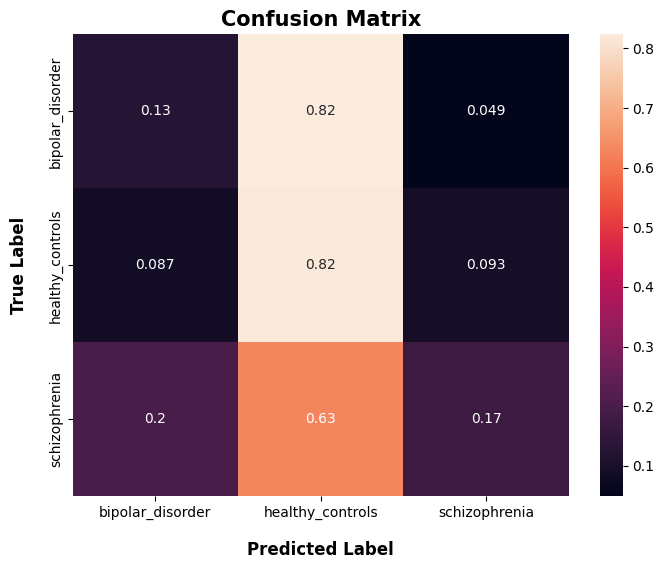

In [23]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in validation_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN1_cm.png')
plt.show()

In [24]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.521942138671875
Precision: 0.4615514572320824
Sensitivity: 0.5219421101774043
Specificity: 0.6862835495693996
